In [3]:

import tensorflow as tf
import requests
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
# import tensorflow_addons as tfa
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import pickle
from tensorflow.keras.models import load_model, Model
from PIL import Image
from PIL.PngImagePlugin import PngImageFile
import matplotlib.pyplot as plt
import glob
from functools import partial

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass
    
    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.16.2


In [4]:
# Downloading the data
#http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#data
import os
import requests
import tarfile

# Retrieve the data
if not os.path.exists(os.path.join('data','VOCtrainval_11-May-2012.tar')):
    url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','VOCtrainval_11-May-2012.tar'), 'wb') as f:
        f.write(r.content)
else:
    print("The tar file already exists.")
    
if not os.path.exists(os.path.join('data', 'VOCtrainval_11-May-2012')):
    with tarfile.open(os.path.join('data','VOCtrainval_11-May-2012.tar'), 'r') as tar:
        tar.extractall('data')
else:
    print("The extracted data already exists")

The tar file already exists.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..224.0].


The format of the data JPEG
This image is of size: (375, 500, 3)
The annotated image is of size: (375, 500)
annot_image pallet:  [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128, 128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128, 64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128, 128, 64, 128, 0, 192, 128, 128, 192, 128, 64, 64, 0, 192, 64, 0, 64, 192, 0, 192, 192, 0, 64, 64, 128, 192, 64, 128, 64, 192, 128, 192, 192, 128, 0, 0, 64, 128, 0, 64, 0, 128, 64, 128, 128, 64, 0, 0, 192, 128, 0, 192, 0, 128, 192, 128, 128, 192, 64, 0, 64, 192, 0, 64, 64, 128, 64, 192, 128, 64, 64, 0, 192, 192, 0, 192, 64, 128, 192, 192, 128, 192, 0, 64, 64, 128, 64, 64, 0, 192, 64, 128, 192, 64, 0, 64, 192, 128, 64, 192, 0, 192, 192, 128, 192, 192, 64, 64, 64, 192, 64, 64, 64, 192, 64, 192, 192, 64, 64, 64, 192, 192, 64, 192, 64, 192, 192, 192, 192, 192, 32, 0, 0, 160, 0, 0, 32, 128, 0, 160, 128, 0, 32, 0, 1

(-0.5, 499.5, 374.5, -0.5)

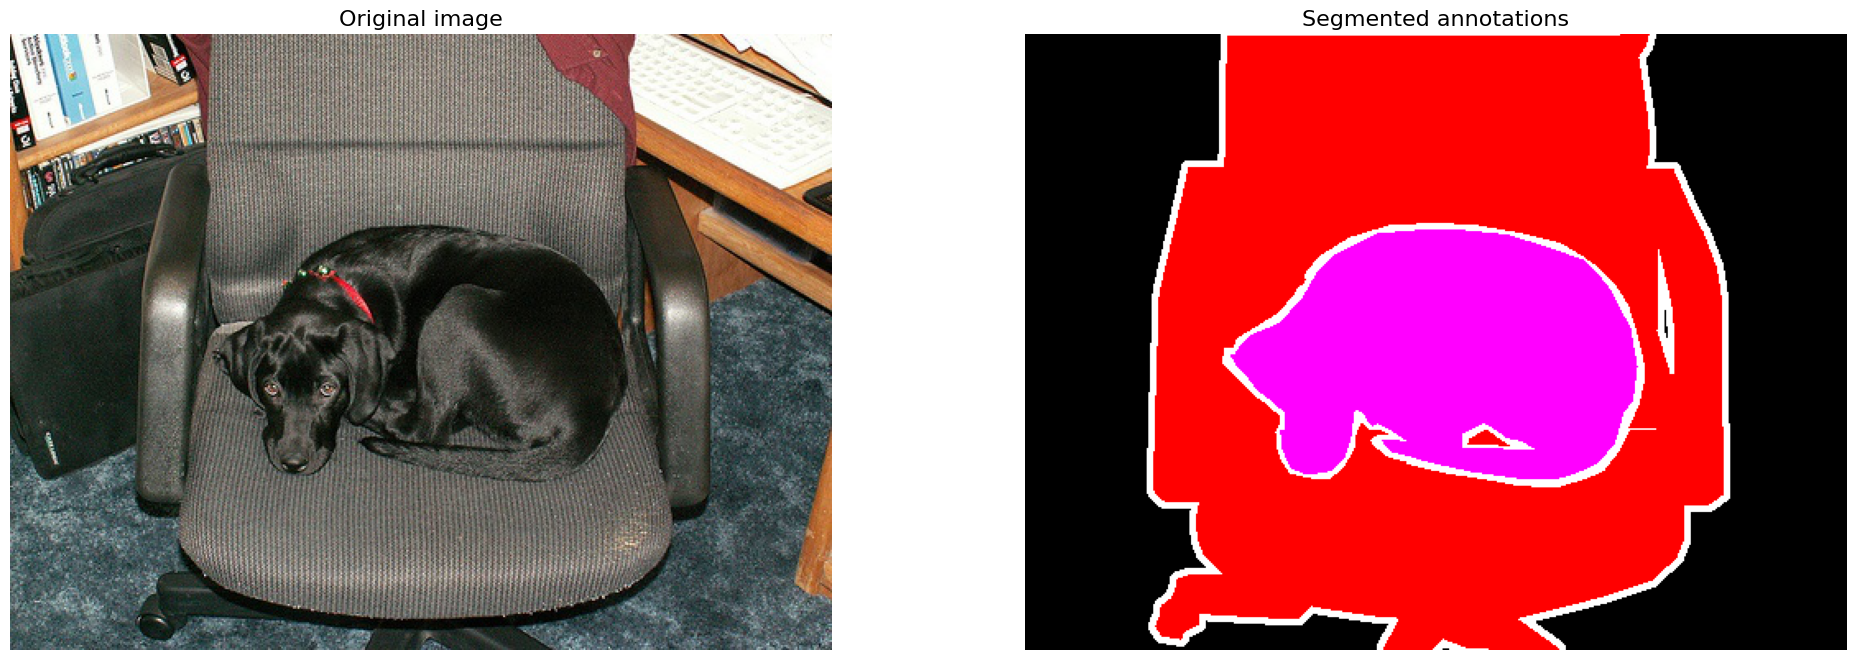

In [6]:
orig_image_path = os.path.join('data',  'VOCdevkit', 'VOC2012', 'JPEGImages', '2007_000063.jpg')
annot_image_path = os.path.join('data', 'VOCdevkit', 'VOC2012', 'SegmentationClass', '2007_000063.png')
                                
orig_image = Image.open(orig_image_path)
print("The format of the data {}".format(orig_image.format))
orig_image = np.array(orig_image)
print("This image is of size: {}".format(orig_image.shape))

annot_image = Image.open(annot_image_path)
print("The annotated image is of size: {}".format(np.array(annot_image).shape))

# Code listing 8.2
def rgb_image_from_pallette(image):
    """ This function restores the RGB values form a palletted PNG image """
    pallette = annot_image.getpalette()
    # Convert the pallet to a sequence of RGB values (n, 3) shape
    pallette = np.array(pallette).reshape(-1,3)
    if isinstance(image, PngImageFile):
        h, w = image.height, image.width
        # Squash height and width dimensions (makes slicing easier)
        image = np.array(image).reshape(-1)
    elif isinstance(image, np.ndarray):
        h, w = image.shape[0], image.shape[1]
        image = image.reshape(-1)
        
    rgb_image = np.zeros(shape=(image.shape[0],3))
    
    # For all locations where image value is not zero, 
    # we replace those locations in the RGB image with the corresponding values from the pallette
    rgb_image[(image != 0),:] = pallette[image[(image != 0)], :]
    rgb_image = rgb_image.reshape(h, w, 3)
    
    return rgb_image

print(f'annot_image pallet: ',annot_image.getpalette())

annot_rgb_image = rgb_image_from_pallette(annot_image)

plt.subplots(1,2, figsize=(24,8))
plt.subplot(1,2,1)
plt.imshow(orig_image)
plt.title("Original image", fontsize=16)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(annot_rgb_image)
plt.title("Segmented annotations", fontsize=16)
plt.axis('off')